# AD Modelling Pipeline

putting it all together pray to god it works

In [20]:
import pickle
import numpy as np
import pandas as pd
from whobpyt.datatypes import par
from whobpyt.models.RWWABT import RNNRWWABT, ParamsRWWABT
from whobpyt.optimization.custom_cost_RWW import CostsRWW
from whobpyt.run import Model_fitting
import torch

import matplotlib.pyplot as plt 
import seaborn as sns

In [21]:
node_size = 100
TPperWindow = 20
step_size = 0.1
tr = 0.75
repeat_size = 5

num_windows = 9    # arbitrary I think

In [22]:
# Load the models from the file
with open('model/cn_abt_model.pkl', 'rb') as f:
    cn_model = pickle.load(f)

with open('model/MCI_abt_model.pkl', 'rb') as f:
    mci_model = pickle.load(f)

with open('model/AD_abt_model.pkl', 'rb') as f:
    ad_model = pickle.load(f)

whole_brain_models = [cn_model, mci_model, ad_model]

with open('../predictors/gbregressor_ventricular_icv.pkl', 'rb') as f:
    predictor = pickle.load(f)

/Users/dyutichakraborty/Documents/ad_modelling_fyp/venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DummyRegressor from version 1.4.1.post1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/dyutichakraborty/Documents/ad_modelling_fyp/venv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/dyutichakraborty/Documents/ad_modelling_fyp/venv/lib/python3.11/site-packages/sklearn/base.py:376:

In [59]:
ts_sim, fc_sim = cn_model.simulate(u =0, num_windows=num_windows, base_window_num=20)

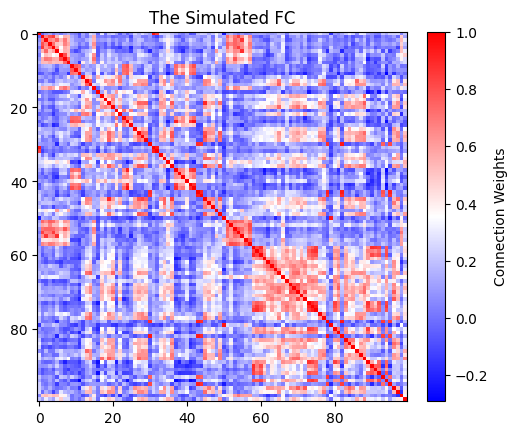

In [66]:
plt.imshow(fc_sim, cmap='bwr')
plt.title('The Simulated FC')
plt.colorbar(fraction=0.046, pad=0.04, label='Connection Weights')
plt.show()

In [23]:
def compute_fc_lower_triangle(fc, node_size=100):
    # Get the lower triangle
    mask_e = np.tril_indices(node_size, -1)
    lower_triangle = fc[mask_e]
    
    return lower_triangle

In [75]:
lower_triangle_fc = compute_fc_lower_triangle(fc_sim)
v = predictor.predict([lower_triangle_fc])

v[0]

0.027113944466532935

0
Group: CN
Group: MCI
Group: AD
1
Group: CN
Group: MCI
Group: AD
2
Group: CN
Group: MCI
Group: AD
3
Group: CN
Group: MCI
Group: AD
4
Group: CN
Group: MCI
Group: AD
5
Group: CN
Group: MCI
Group: AD
6
Group: CN
Group: MCI
Group: AD
7
Group: CN
Group: MCI
Group: AD
8
Group: CN
Group: MCI
Group: AD
9
Group: CN
Group: MCI
Group: AD
10
Group: CN
Group: MCI
Group: AD
11
Group: CN
Group: MCI
Group: AD
12
Group: CN
Group: MCI
Group: AD
13
Group: CN
Group: MCI
Group: AD
14
Group: CN
Group: MCI
Group: AD
15
Group: CN
Group: MCI
Group: AD
16
Group: CN
Group: MCI
Group: AD
17
Group: CN
Group: MCI
Group: AD
18
Group: CN
Group: MCI
Group: AD
19
Group: CN
Group: MCI
Group: AD
20
Group: CN
Group: MCI
Group: AD
21
Group: CN
Group: MCI
Group: AD
22
Group: CN
Group: MCI
Group: AD
23
Group: CN
Group: MCI
Group: AD
24
Group: CN
Group: MCI
Group: AD


/var/folders/kc/0zmcgk1j313586f5z7yvtgjh0000gn/T/ipykernel_69316/3462362970.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(ventricular_icv, labels=groups)


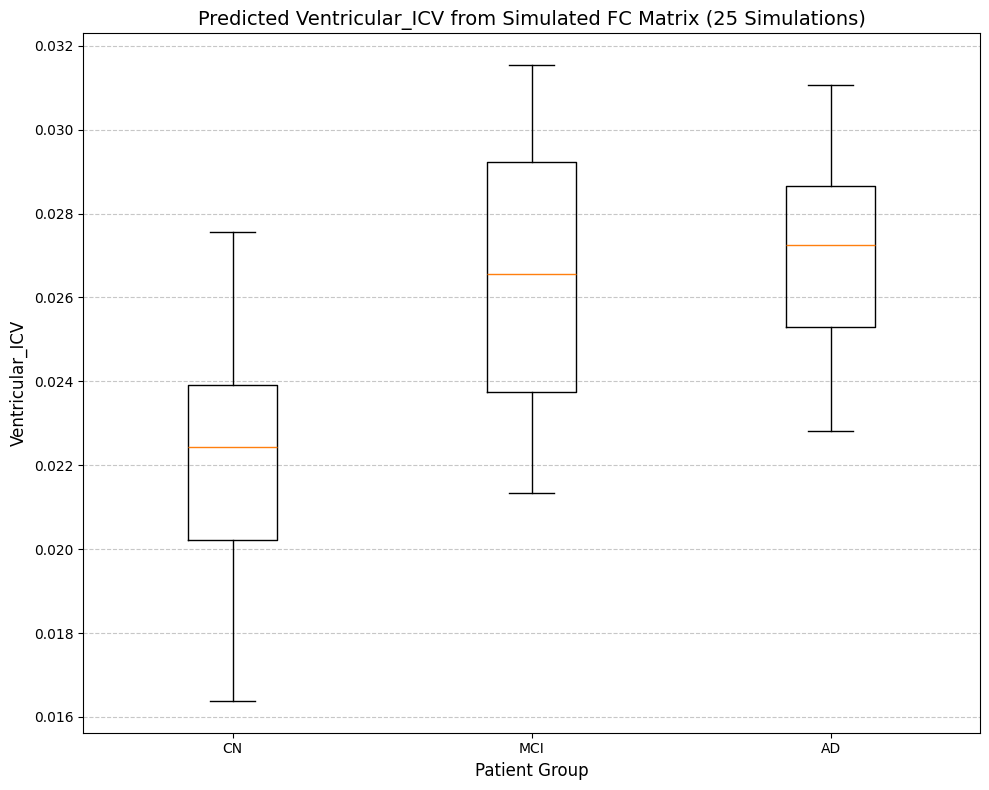

In [85]:
groups = ['CN', 'MCI', 'AD']
ventricular_icv = [[], [], []]

for i in range(25):
    print(i)
    for i in range(len(groups)):
        print(f'Group: {groups[i]}')
        model = whole_brain_models[i]

        _, fc = model.simulate(u =0, num_windows=num_windows, base_window_num=20)
        lower_triangle_fc = compute_fc_lower_triangle(fc)
        v = predictor.predict([lower_triangle_fc])
        ventricular_icv[i].append(v[0])

# colors = plt.cm.viridis(np.linspace(0, 1, len(groups)))

plt.figure(figsize=(10, 8))
plt.boxplot(ventricular_icv, labels=groups)
# plt.bar(groups, ventricular_icv, color=colors)

plt.title('Predicted Ventricular_ICV from Simulated FC Matrix (25 Simulations)', fontsize=14)
plt.xlabel('Patient Group', fontsize=12)
plt.ylabel('Ventricular_ICV', fontsize=12)


# plt.xticks(rotation=45, ha='right', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

## Vary CN + AD params + structural connectivity

In [35]:
cn_fitted_sc = cn_model.model.sc_fitted.detach().numpy()

cn_fitted_bAB_E = cn_model.trainingStats.fit_params['bAB_E'][-1]
cn_fitted_sAB_E = cn_model.trainingStats.fit_params['sAB_E'][-1]
cn_fitted_bt_E = cn_model.trainingStats.fit_params['bt_E'][-1]
cn_fitted_st_E = cn_model.trainingStats.fit_params['st_E'][-1]
cn_fitted_bAB_I = cn_model.trainingStats.fit_params['bAB_I'][-1]
cn_fitted_sAB_I = cn_model.trainingStats.fit_params['sAB_I'][-1]

In [36]:
ad_fitted_sc = ad_model.model.sc_fitted.detach().numpy()

ad_fitted_bAB_E = ad_model.trainingStats.fit_params['bAB_E'][-1]
ad_fitted_sAB_E = ad_model.trainingStats.fit_params['sAB_E'][-1]
ad_fitted_bt_E = ad_model.trainingStats.fit_params['bt_E'][-1]
ad_fitted_st_E = ad_model.trainingStats.fit_params['st_E'][-1]
ad_fitted_bAB_I = ad_model.trainingStats.fit_params['bAB_I'][-1]
ad_fitted_sAB_I = ad_model.trainingStats.fit_params['sAB_I'][-1]

In [37]:
def define_model(fitted_sc, pgroup, fitted_bAB_E, fitted_sAB_E, fitted_bt_E, fitted_st_E, fitted_bAB_I, fitted_sAB_I):
    params = ParamsRWWABT(bAB_E=par(val=fitted_bAB_E, fit_par=True), sAB_E=par(val=fitted_sAB_E, fit_par=True), bt_E=par(val=fitted_bt_E, fit_par=True),
                          st_E=par(val=fitted_st_E, fit_par=True), bAB_I=par(val=fitted_bAB_I, fit_par=True), sAB_I=par(val=fitted_sAB_I, fit_par=True))

    abeta_file = np.genfromtxt(f'../data/avg_scans/AB_{pgroup}.csv', delimiter=",")
    abeta = torch.tensor(abeta_file, dtype=torch.float32)

    tau_file = np.genfromtxt(f'../data/avg_scans/TAU_{pgroup}.csv', delimiter=",")
    tau = torch.tensor(tau_file, dtype=torch.float32)

    model = RNNRWWABT(node_size, TPperWindow, step_size, repeat_size, tr, fitted_sc, abeta, tau, True, params)

    ObjFun = CostsRWW(model)

    F = Model_fitting(model, ObjFun)
    
    return F

def simulate_FC(F):
    _, fc_sim = F.simulate(u =0, num_windows=num_windows, base_window_num=20)
    return fc_sim

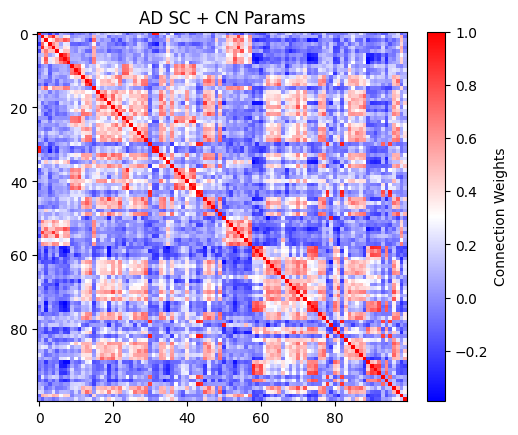

In [38]:
# Try varying the SC and params combo

model = define_model(ad_fitted_sc, 'CN', cn_fitted_bAB_E, cn_fitted_sAB_E, cn_fitted_bt_E, cn_fitted_st_E, cn_fitted_bAB_I, cn_fitted_sAB_I)
fc_sim = simulate_FC(model)

plt.imshow(fc_sim, cmap='bwr')
plt.title('AD SC + CN Params')
plt.colorbar(fraction=0.046, pad=0.04, label='Connection Weights')
plt.show()

In [39]:
# define all parameter combinations
ad_sc_ad_params = {
    'fitted_sc': ad_fitted_sc,
    'pgroup': 'AD',  
    'fitted_bAB_E': ad_fitted_bAB_E, 
    'fitted_sAB_E': ad_fitted_sAB_E, 
    'fitted_bt_E': ad_fitted_bt_E, 
    'fitted_st_E': ad_fitted_st_E, 
    'fitted_bAB_I': ad_fitted_bAB_I, 
    'fitted_sAB_I': ad_fitted_sAB_I
}

ad_sc_cn_params = {
    'fitted_sc': ad_fitted_sc, 
    'pgroup': 'CN', 
    'fitted_bAB_E': cn_fitted_bAB_E, 
    'fitted_sAB_E': cn_fitted_sAB_E, 
    'fitted_bt_E': cn_fitted_bt_E, 
    'fitted_st_E': cn_fitted_st_E, 
    'fitted_bAB_I': cn_fitted_bAB_I, 
    'fitted_sAB_I': cn_fitted_sAB_I
}

cn_sc_ad_params = {
    'fitted_sc': cn_fitted_sc, 
    'pgroup': 'AD', 
    'fitted_bAB_E': ad_fitted_bAB_E, 
    'fitted_sAB_E': ad_fitted_sAB_E, 
    'fitted_bt_E': ad_fitted_bt_E, 
    'fitted_st_E': ad_fitted_st_E, 
    'fitted_bAB_I': ad_fitted_bAB_I, 
    'fitted_sAB_I': ad_fitted_sAB_I
}

cn_sc_cn_params = {
    'fitted_sc': cn_fitted_sc,
    'pgroup': 'CN',  
    'fitted_bAB_E': cn_fitted_bAB_E, 
    'fitted_sAB_E': cn_fitted_sAB_E, 
    'fitted_bt_E': cn_fitted_bt_E, 
    'fitted_st_E': cn_fitted_st_E, 
    'fitted_bAB_I': cn_fitted_bAB_I, 
    'fitted_sAB_I': cn_fitted_sAB_I
}

In [40]:
groups = ['AD SC + AD Params', 'AD SC + CN Params', 'CN SC + AD Params', 'CN SC + CN Params']
param_sets = [ad_sc_ad_params, ad_sc_cn_params, cn_sc_ad_params, cn_sc_cn_params]

ventricular_icv = []

for i in range(len(groups)):
    print(f'Trial: {groups[i]}')
    model = define_model(**param_sets[i])
    simulations = []
    for i in range(25):
        fc = simulate_FC(model)
        lower_triangle_fc = compute_fc_lower_triangle(fc)
        simulations.append(lower_triangle_fc)
        
    v = predictor.predict(simulations)
    ventricular_icv.append(v)
    

Trial: AD SC + AD Params
Trial: AD SC + CN Params
Trial: CN SC + AD Params
Trial: CN SC + CN Params


/var/folders/kc/0zmcgk1j313586f5z7yvtgjh0000gn/T/ipykernel_72676/3692693708.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(ventricular_icv, labels=groups)


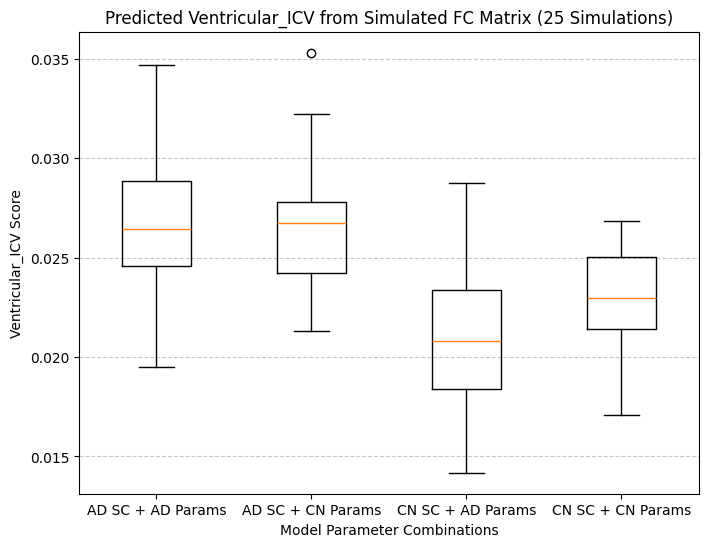

In [41]:
# colors = plt.cm.viridis(np.linspace(0, 1, len(groups)))

plt.figure(figsize=(8, 6))
plt.boxplot(ventricular_icv, labels=groups)
# plt.bar(groups, ventricular_icv, color=colors)

plt.title('Predicted Ventricular_ICV from Simulated FC Matrix (25 Simulations)')
plt.xlabel('Model Parameter Combinations')
plt.ylabel('Ventricular_ICV Score')


plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('sc_and_param_combos_predicted_scores.png')
plt.show()

## Ventricular prediction from varying sAB_E

In [42]:
sAB_E_data = np.loadtxt('../data/prediction_res/trialled_sAB_E_short.txt')
predicted_ventr = np.loadtxt('../data/prediction_res/predicted_ventr_icv_sAB_E_short.txt')

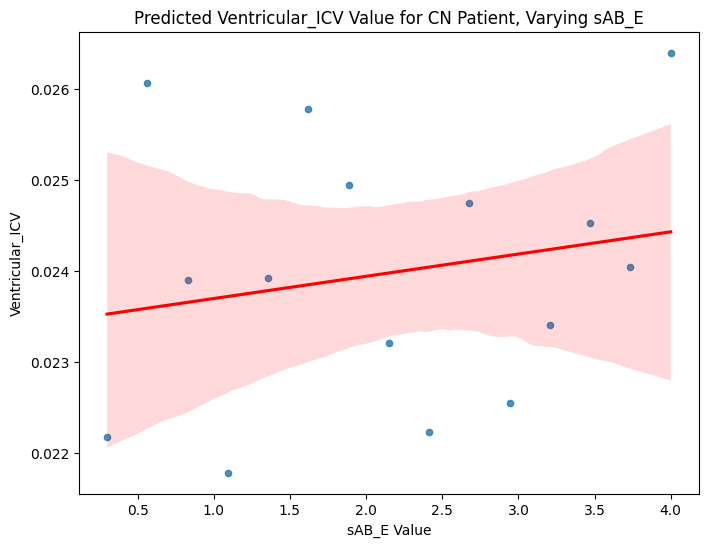

In [43]:
plt.figure(figsize=(8,6))
sns.regplot(x=sAB_E_data, y=predicted_ventr, line_kws={'color':'red'}, scatter_kws={'s':20})
plt.title('Predicted Ventricular_ICV Value for CN Patient, Varying sAB_E')
plt.xlabel('sAB_E Value')
plt.ylabel('Ventricular_ICV')
plt.show()